In [1]:
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
from specim.specfuncs import spec1d
import numpy as np
import matplotlib.pyplot as plt
import glob
from random import sample
import pandas as pd
import seaborn as sn
import pm_veldis_util as vd
from collections import Counter

In [2]:
data =  spec1d.Spec1d('../J0659gal.txt')
lamda_galaxy = data['wav']
spectra_galaxy = data['flux']
variance_spectra_galaxy = data['var']
lamda_galaxy_range =  [np.min(lamda_galaxy), np.max(lamda_galaxy)]


Reading spectrum from ../J0659gal.txt
Expected file format: text
 Spectrum Start:  5592.31
 Spectrum End:     7244.38
 Dispersion (1st pixel):   0.40
 Dispersion (average):      0.40




Line        lambda_rest  lambda_obs
----------  -----------  -----------
H-kappa       3750.00       6624.75
[Fe VII]      3761.40       6644.89
H-iota        3770.00       6660.08
H-theta       3797.00       6707.78
H-eta         3835.00       6774.91
CN bandhd     3883.00       6859.71
CaII K        3933.67       6949.22
CaII H        3968.47       7010.70



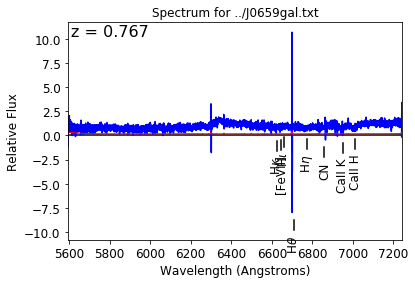

In [3]:
data.plot()
data.mark_lines('abs', z=0.7666)


Line        lambda_rest  lambda_obs
----------  -----------  -----------
H-kappa       3750.00       6624.75
[Fe VII]      3761.40       6644.89
H-iota        3770.00       6660.08
H-theta       3797.00       6707.78
H-eta         3835.00       6774.91
CN bandhd     3883.00       6859.71
CaII K        3933.67       6949.22
CaII H        3968.47       7010.70



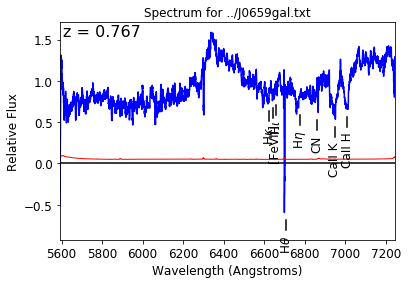

In [5]:
data.smooth(11)
data.mark_lines('abs', z=0.7666, usesmooth=True)


Line        lambda_rest  lambda_obs
----------  -----------  -----------
H-kappa       3750.00       6624.75
[Fe VII]      3761.40       6644.89
H-iota        3770.00       6660.08
H-theta       3797.00       6707.78
H-eta         3835.00       6774.91
CN bandhd     3883.00       6859.71
CaII K        3933.67       6949.22
CaII H        3968.47       7010.70



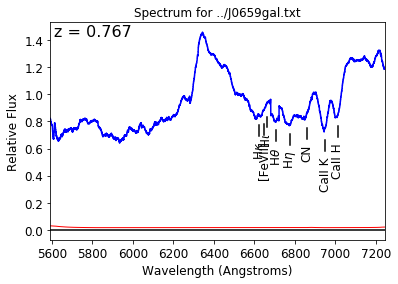

In [22]:
data.smooth(101)
data.mark_lines('abs', z=0.7666, usesmooth=True)

/home/pritom/anaconda3/lib/python3.7/site-packages/specim/specfuncs/spec1d.py:1022: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  plt.plot(self['wav'], skyflux, ls=ls, color=color, label=lab)


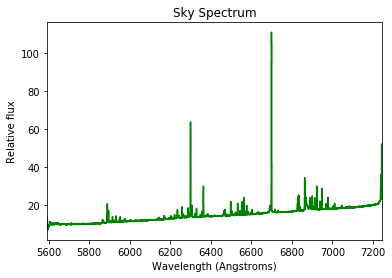

In [23]:
data.plot_sky()

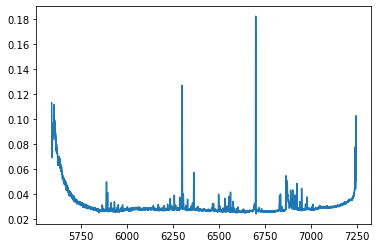

In [24]:
plt.plot(lamda_galaxy, variance_spectra_galaxy)